In [293]:
import numpy as np
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space fermion basis
from quspin.tools.block_tools import block_diag_hamiltonian # block diagonalisation
import sys,os
from matplotlib import pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='6' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='6' # set number of MKL threads to run in parallel
os.environ['MKL_DEBUG_CPU_TYPE'] = '5'
import scienceplots
plt.style.use(['science','ieee'])
plt.rcParams['text.usetex'] = True
from scipy.stats import gaussian_kde
from scipy.signal import *
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

In [2]:
## Model parameters
L = 1
Ja=-9.3 # /2 Pi 
Je=-6.1
jx = np.random.normal(size = L-3)*np.pi
Omega=3*np.pi
J_nn = 0.3
basis = spin_basis_1d(L,Nup=int(L/2), pauli = 0)
i_0 = basis.index('1001100110011001')

In [4]:
ja_hop_pm,je_hop_pm,ja_hop_mp,je_hop_mp,omega,j_nn = [],[],[],[],[],[]
for i in range(L-1):
    if i%2 == 0:
        ja_hop_pm+=[[Ja,i,(i+1)]]
        ja_hop_mp+=[[Ja,i,(i+1)]]
    else:
        je_hop_pm+=[[Je,i,(i+1)]]
        je_hop_mp+=[[Je,i,(i+1)]]
#Staircase potential
for n in range(int(L/2)):
    site = 2*n
    omega_val =0.8*n
    omega += [[omega_val,site,site],[omega_val,site-1,site-1]]
    
# next-next-nearest
for i in range(L-3):
    j_nn += [[J_nn,i,i+3]]
#for i in range(L-3):
    #jx_nn += [[jx[i]/2,i,i+2]]

In [5]:
static = [['+-',ja_hop_pm],['-+',ja_hop_mp],['+-',je_hop_pm],['-+',je_hop_mp],['+-',omega],['+-',j_nn],['-+',j_nn]]
dynamic = []

In [224]:
S_n, S_nn = [],[]
for i in range(L):
    if (i+1)%4 not in [0,1]:
        S_n += [[1,i]]
    else:
        S_n += [[-1,i]]
static2 = [['z',S_n]]
H_QFI = hamiltonian(static2,dynamic,basis=basis)

Hermiticity check passed!
Particle conservation check passed!


C:\Users\Charlie\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  


In [7]:
H= hamiltonian(static,dynamic, basis=basis)

Hermiticity check passed!
Particle conservation check passed!


C:\Users\Charlie\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  """Entry point for launching an IPython kernel.


In [8]:
eigenvalues,eigenvectors = H.eigh()

In [281]:
psi_0 = np.zeros(basis.Ns)
psi_0_thermal = np.zeros(basis.Ns)
psi_0[i_0]=1
psi_0_thermal[600]=1
times = np.linspace(0,50,10000)

In [282]:
psi_t = H.evolve(psi_0,times.min(),times)
psi_t_thermal = H.evolve(psi_0_thermal,times.min(),times)

In [261]:
entropies = []
pa_t = []
thermal_entropies = []
for i in range(len(times)):
    entropies.append(basis.ent_entropy(psi_t[:,i],sub_sys_A = [0,1,2,3])['Sent_A'])
    thermal_entropies.append(basis.ent_entropy(psi_t_thermal[:,i],sub_sys_A = [0,1,2,3])['Sent_A'])
    pa_t.append(basis.partial_trace(psi_t[:,i],[0,1,2,3]))

KeyboardInterrupt: 

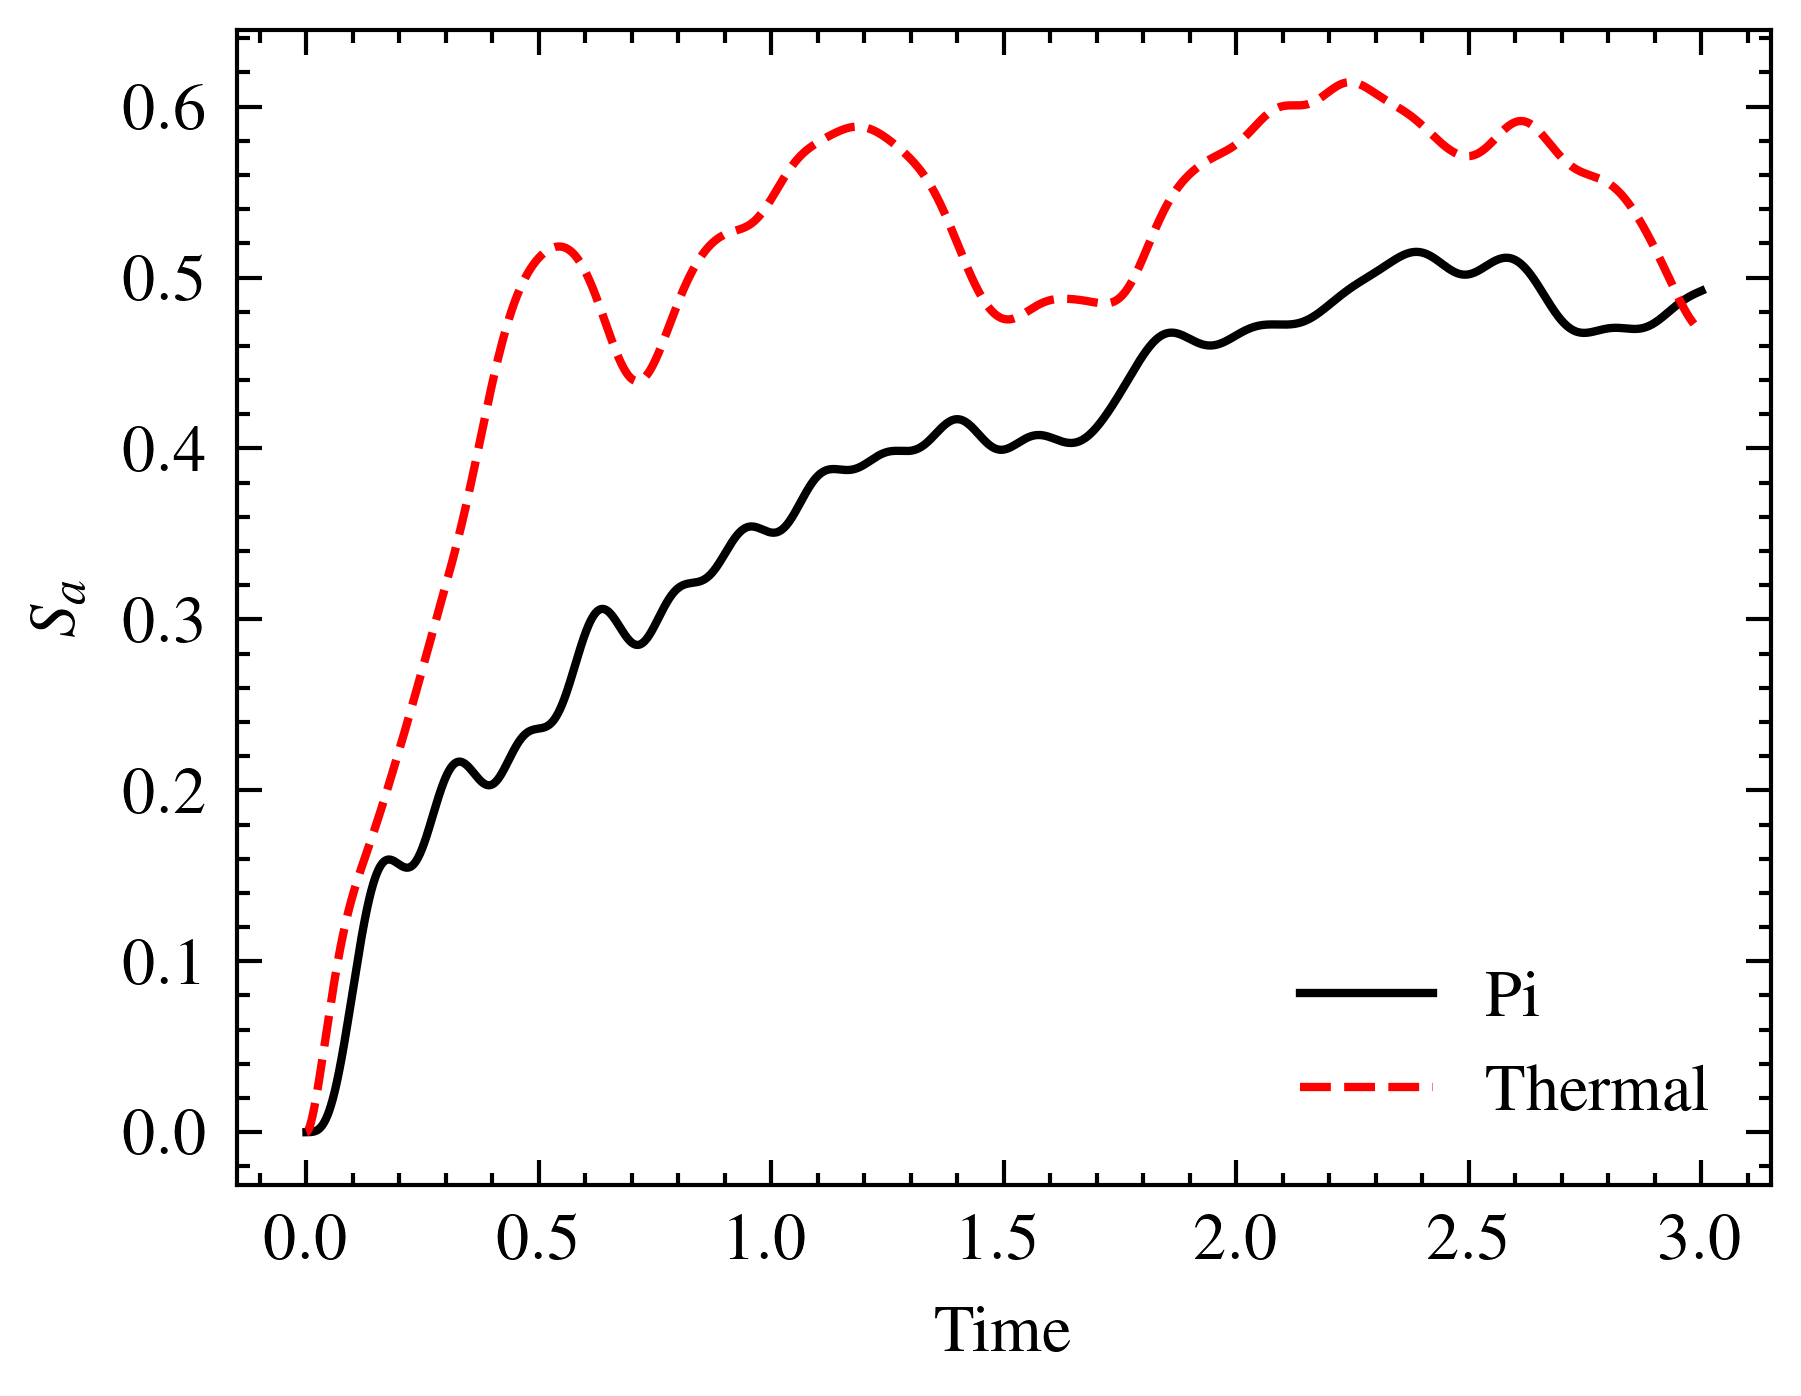

In [254]:
plt.plot(times,entropies,label = 'Pi')
plt.plot(times,thermal_entropies,label = 'Thermal')
plt.xlabel('Time')
plt.ylabel(r'$S_a$')
plt.legend()

In [255]:
#Dynamics of Fidelity
timefidels = []
thermfidels =[]
for i in range(len(times)):
    timefidels.append(np.abs(np.vdot(psi_0,psi_t[:,i])**2))
    thermfidels.append(np.abs(np.vdot(psi_0_thermal,psi_t_thermal[:,i])**2))

Text(0, 0.5, 'Fidelity')

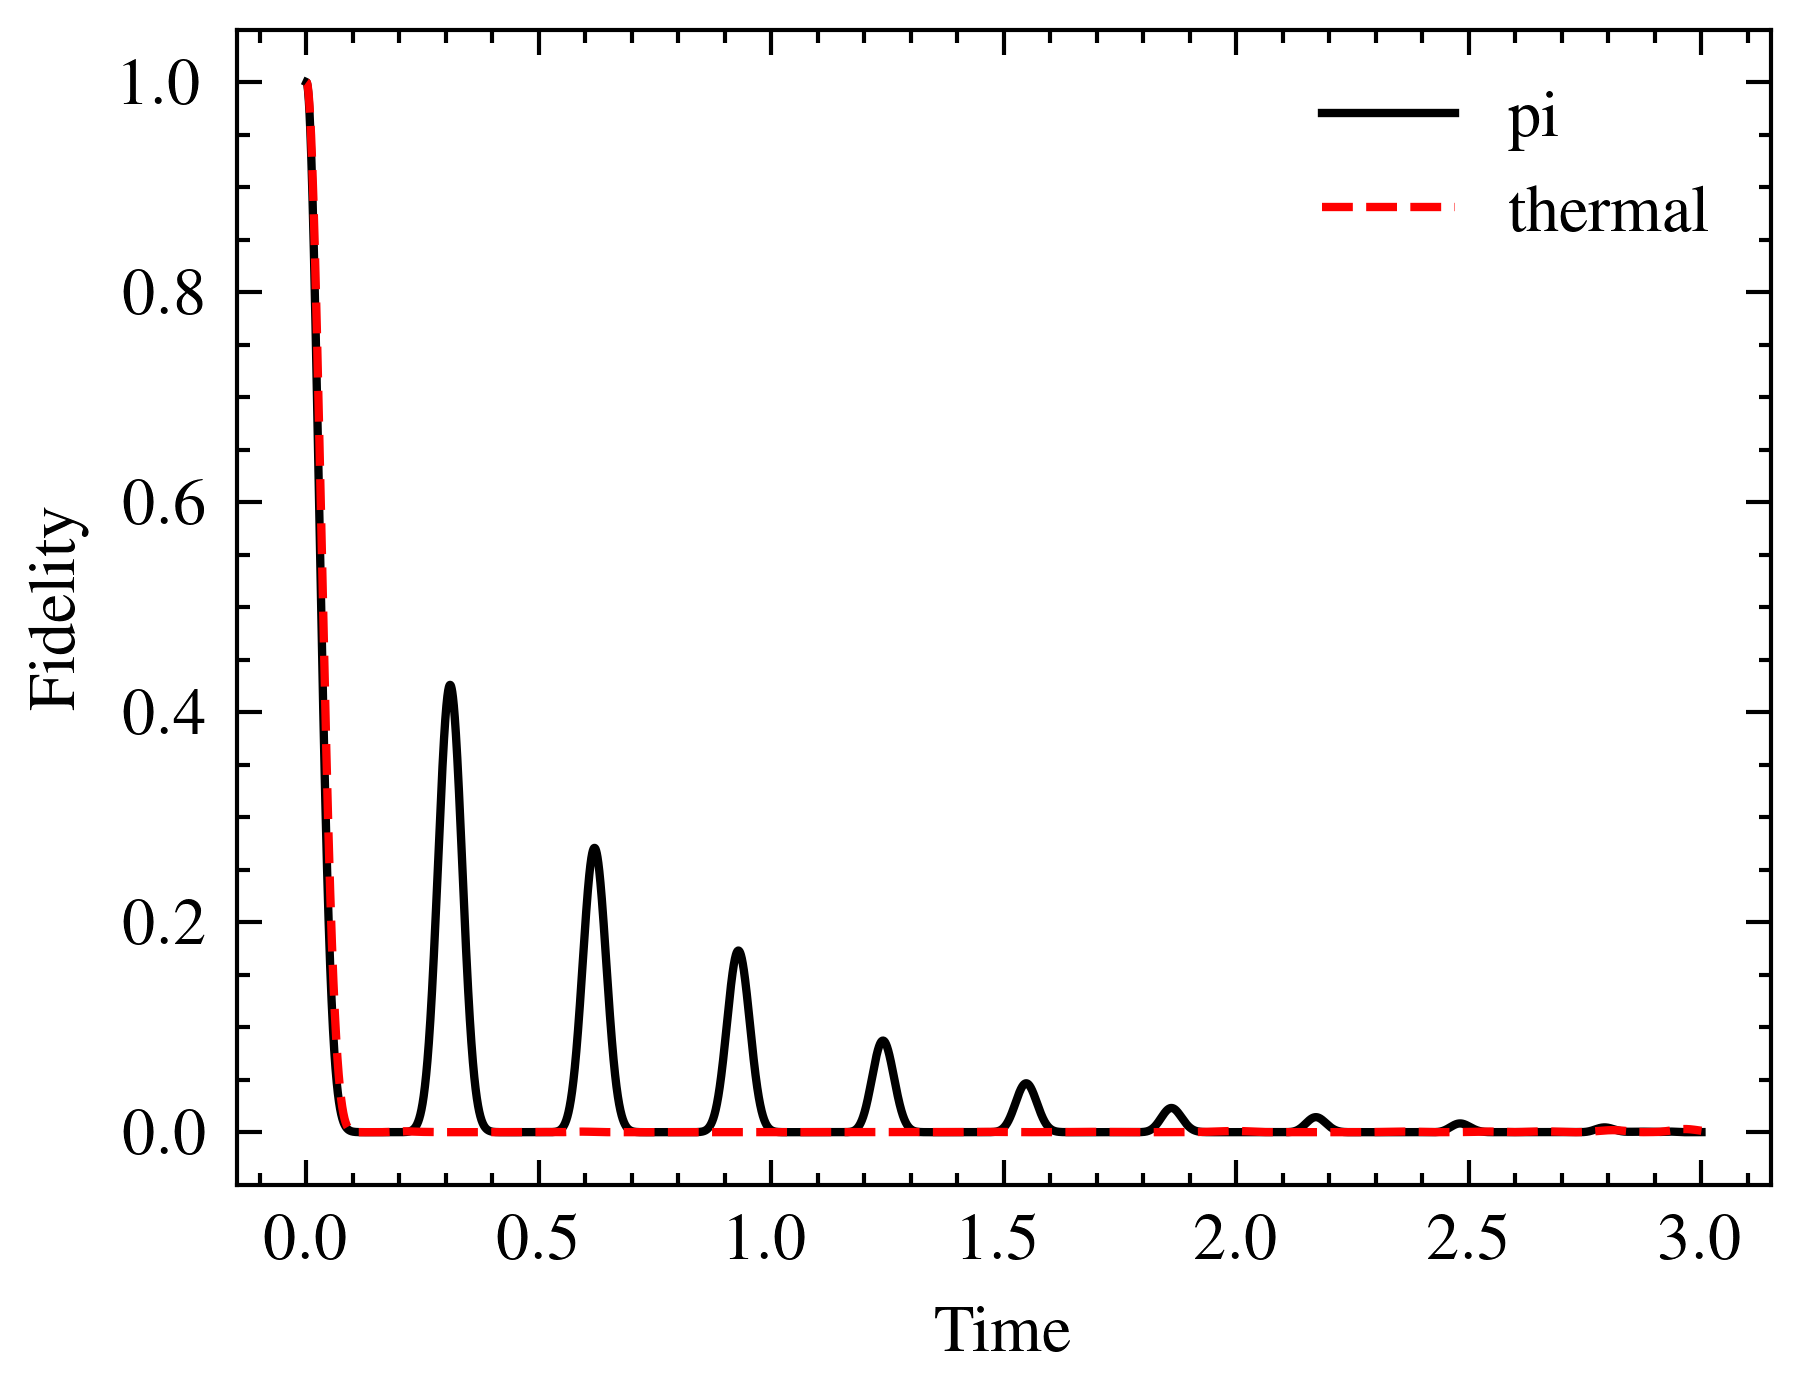

In [256]:
plt.plot(times,timefidels,label='pi')
plt.plot(times,thermfidels,label='thermal')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Fidelity')

In [257]:
fidelsoverlap = []
for i in range(len(eigenvectors)):
    fidelsoverlap.append(np.abs(np.vdot(psi_0,eigenvectors[:,i])**2)/L)
    

In [335]:
z = find_peaks(fidelsoverlap,height = 10**-3.8,distance=450)[0]
print(len(z))
print(z)
fz_i = []
En_zI = []
S_z_i,En_s_i = [] ,[]
for i in (z):
    En_zI.append(eigenvalues[i])
    fz_i.append(fidelsoverlap[i])
    S_z_i.append(eigen_entropies[i])
    En_s_i.append(eigenvalues[i]/L)

7
[   39   507  2405  6348 10318 12376 12830]


In [334]:
S_z_i

[0.021289594333576887,
 0.03140925670317171,
 0.04117498946451155,
 0.04227252420094142,
 0.04222812285065107,
 0.030300002313098758,
 0.02128959433357747]

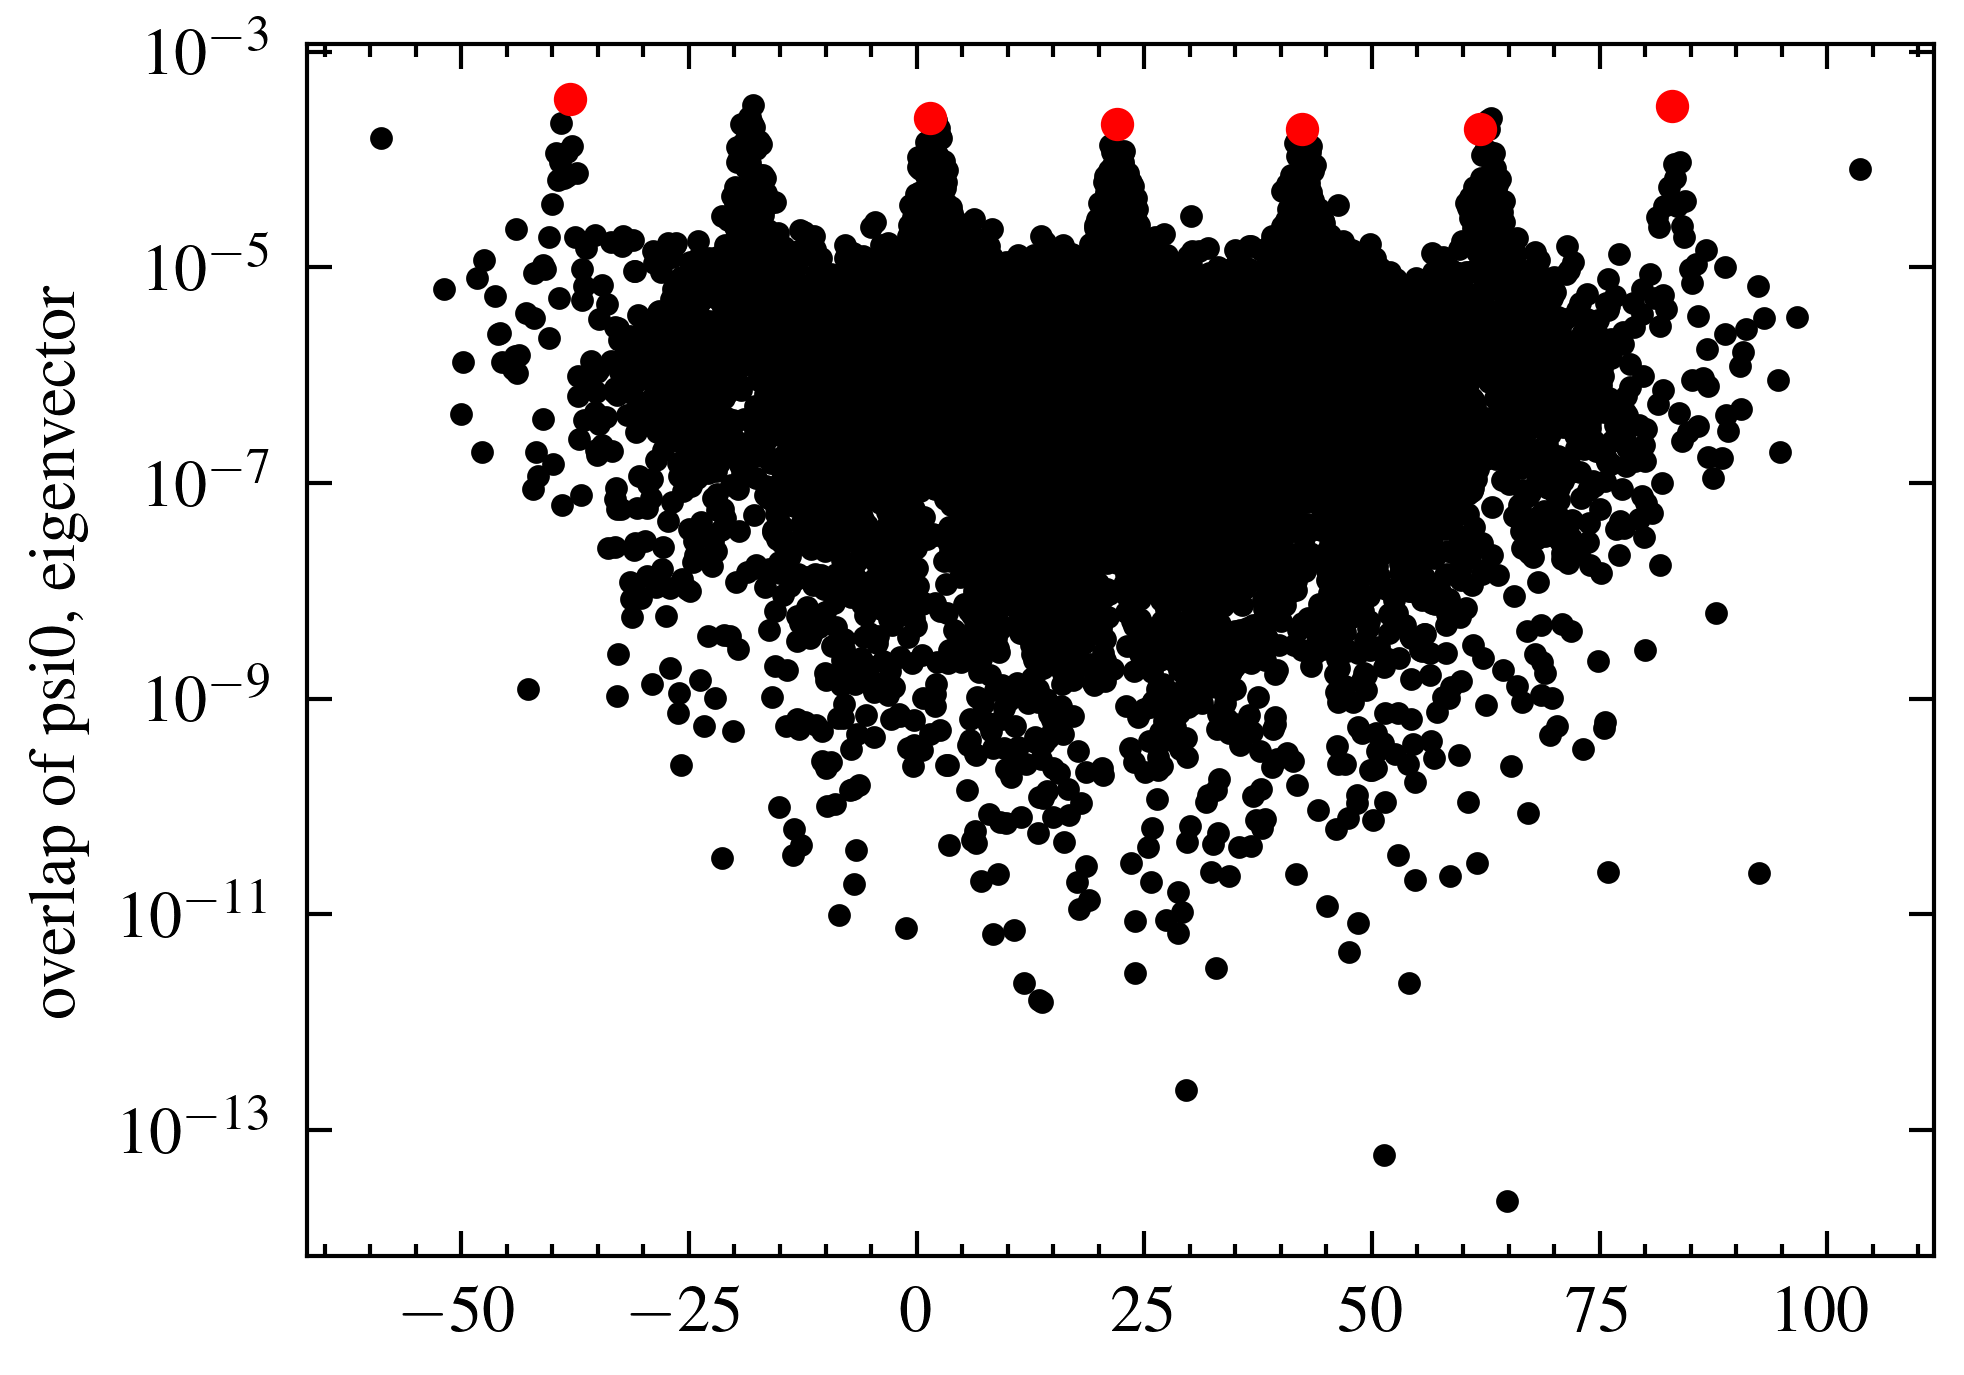

<Figure size 2100x1575 with 0 Axes>

In [328]:
with plt.style.context(['science', 'scatter']):
    plt.scatter(eigenvalues,fidelsoverlap,s=3,c='black')
    plt.yscale('log')
    plt.ylabel('overlap of psi0, eigenvector')
    plt.scatter(En_zI,fz_i,c='red')
    #plt.xlim(left =-40,right = -35)
    fig=plt.figure()

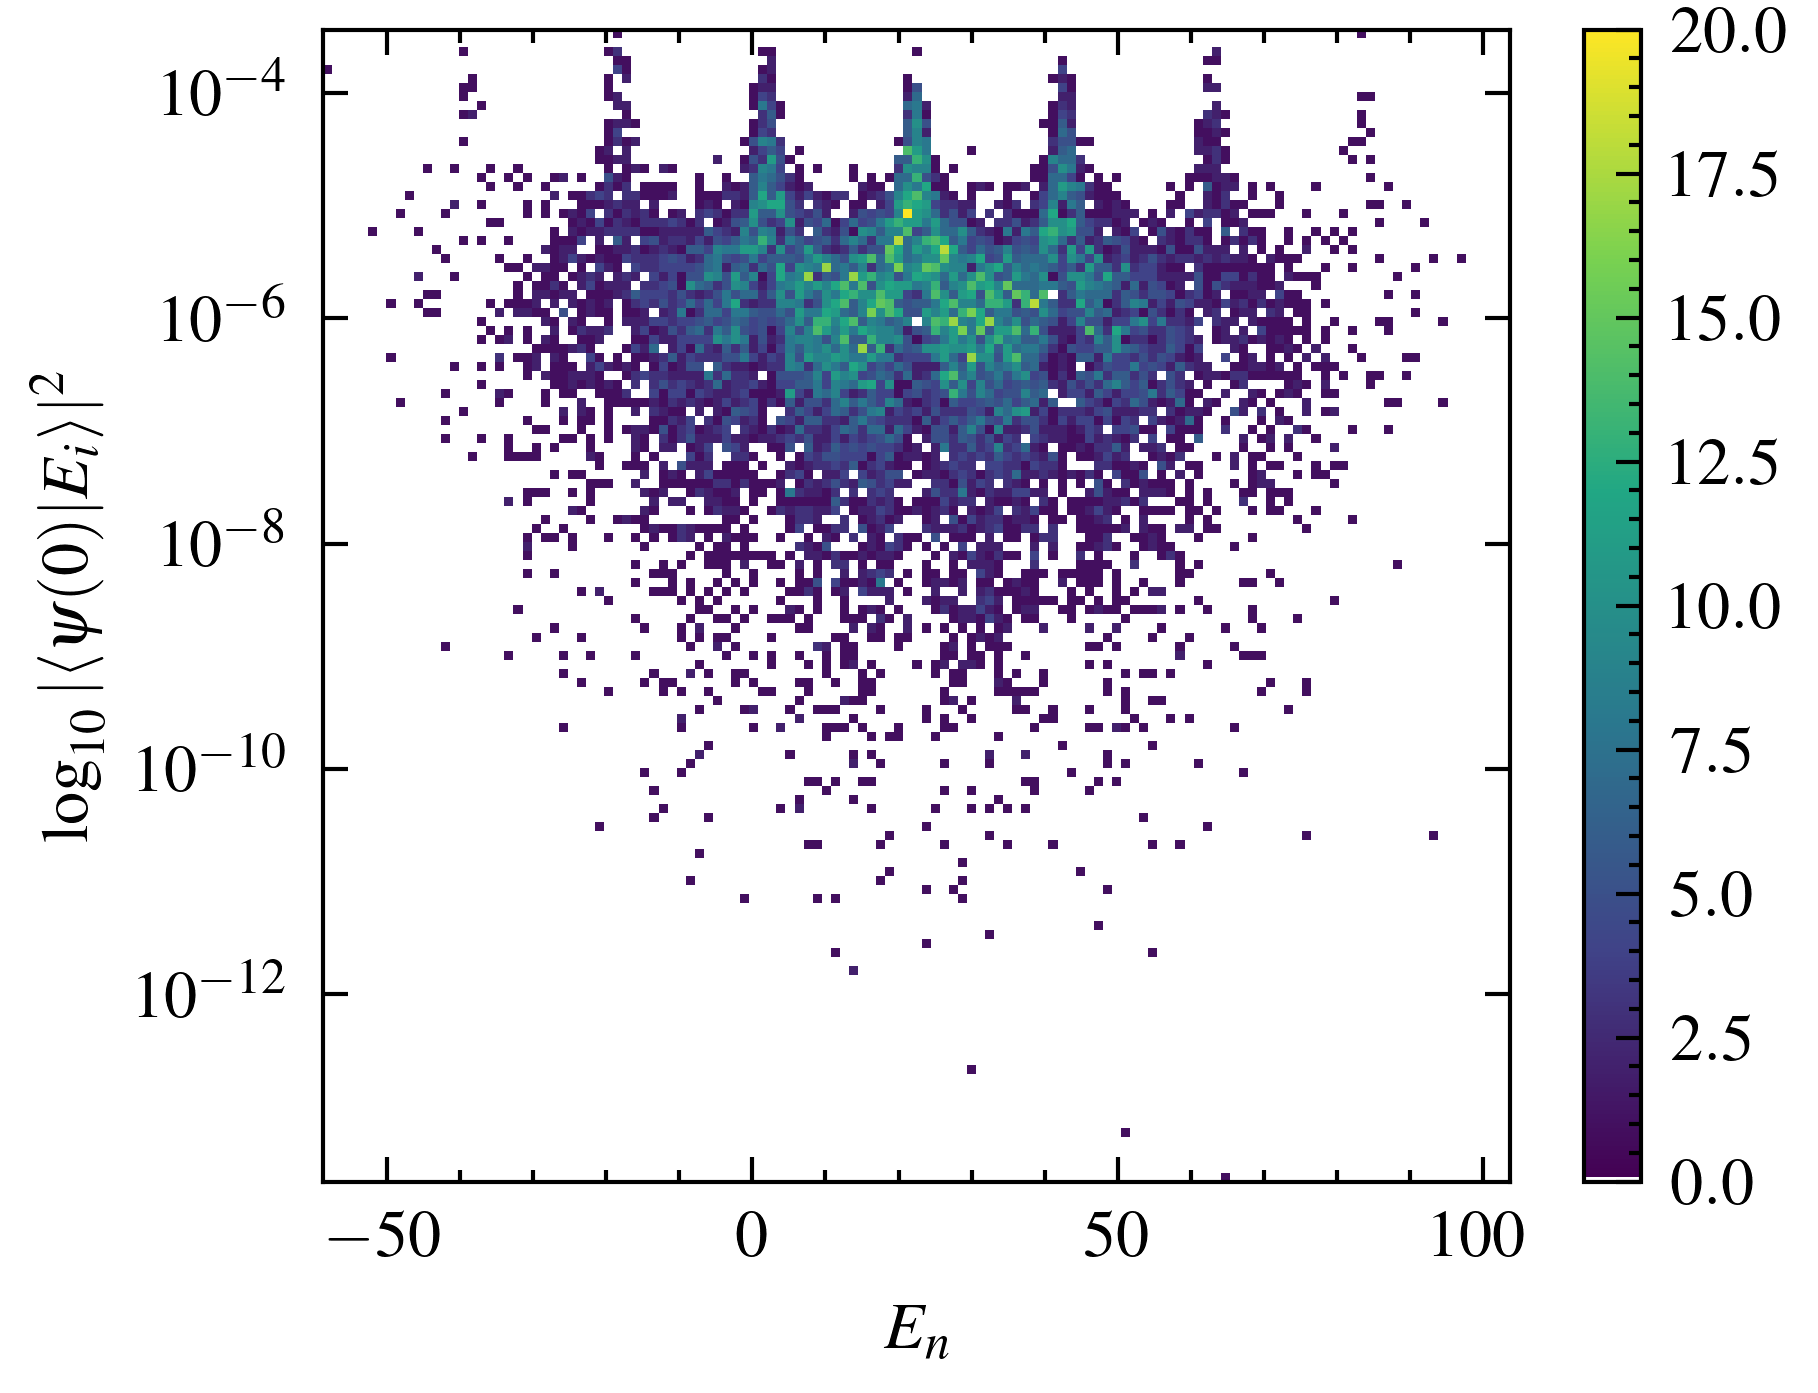

In [88]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(eigenvalues, fidelsoverlap, cmap=white_viridis)
    fig.colorbar(density)

fig = plt.figure()
using_mpl_scatter_density(fig, eigenvalues, fidelsoverlap)
plt.yscale('log')

plt.ylabel(r'$\log_{10}|\langle\psi(0)|E_i\rangle|^2$')
plt.xlabel(r'$E_n$')
plt.tight_layout()
plt.show()

In [45]:
spacing = []
for i in range(int(0.25*len(eigenvalues)),int(0.75*len(eigenvalues))):
    space = eigenvalues[i+1] - eigenvalues[i]
    #if space != 0:
    spacing.append(space)
S_i = spacing/np.mean(spacing)
Poisson=[]
Wigner_Dyson = []
for i in np.linspace(0,S_i.max()):
    Poisson.append(np.exp(-1*i))
    Wigner_Dyson.append((i*np.pi/2)*np.exp((-np.pi/4)*(i**2)))


In [26]:
S_i

array([1.66792673, 1.28248698, 1.177084  , ..., 1.177084  , 1.28248698,
       1.66792673])

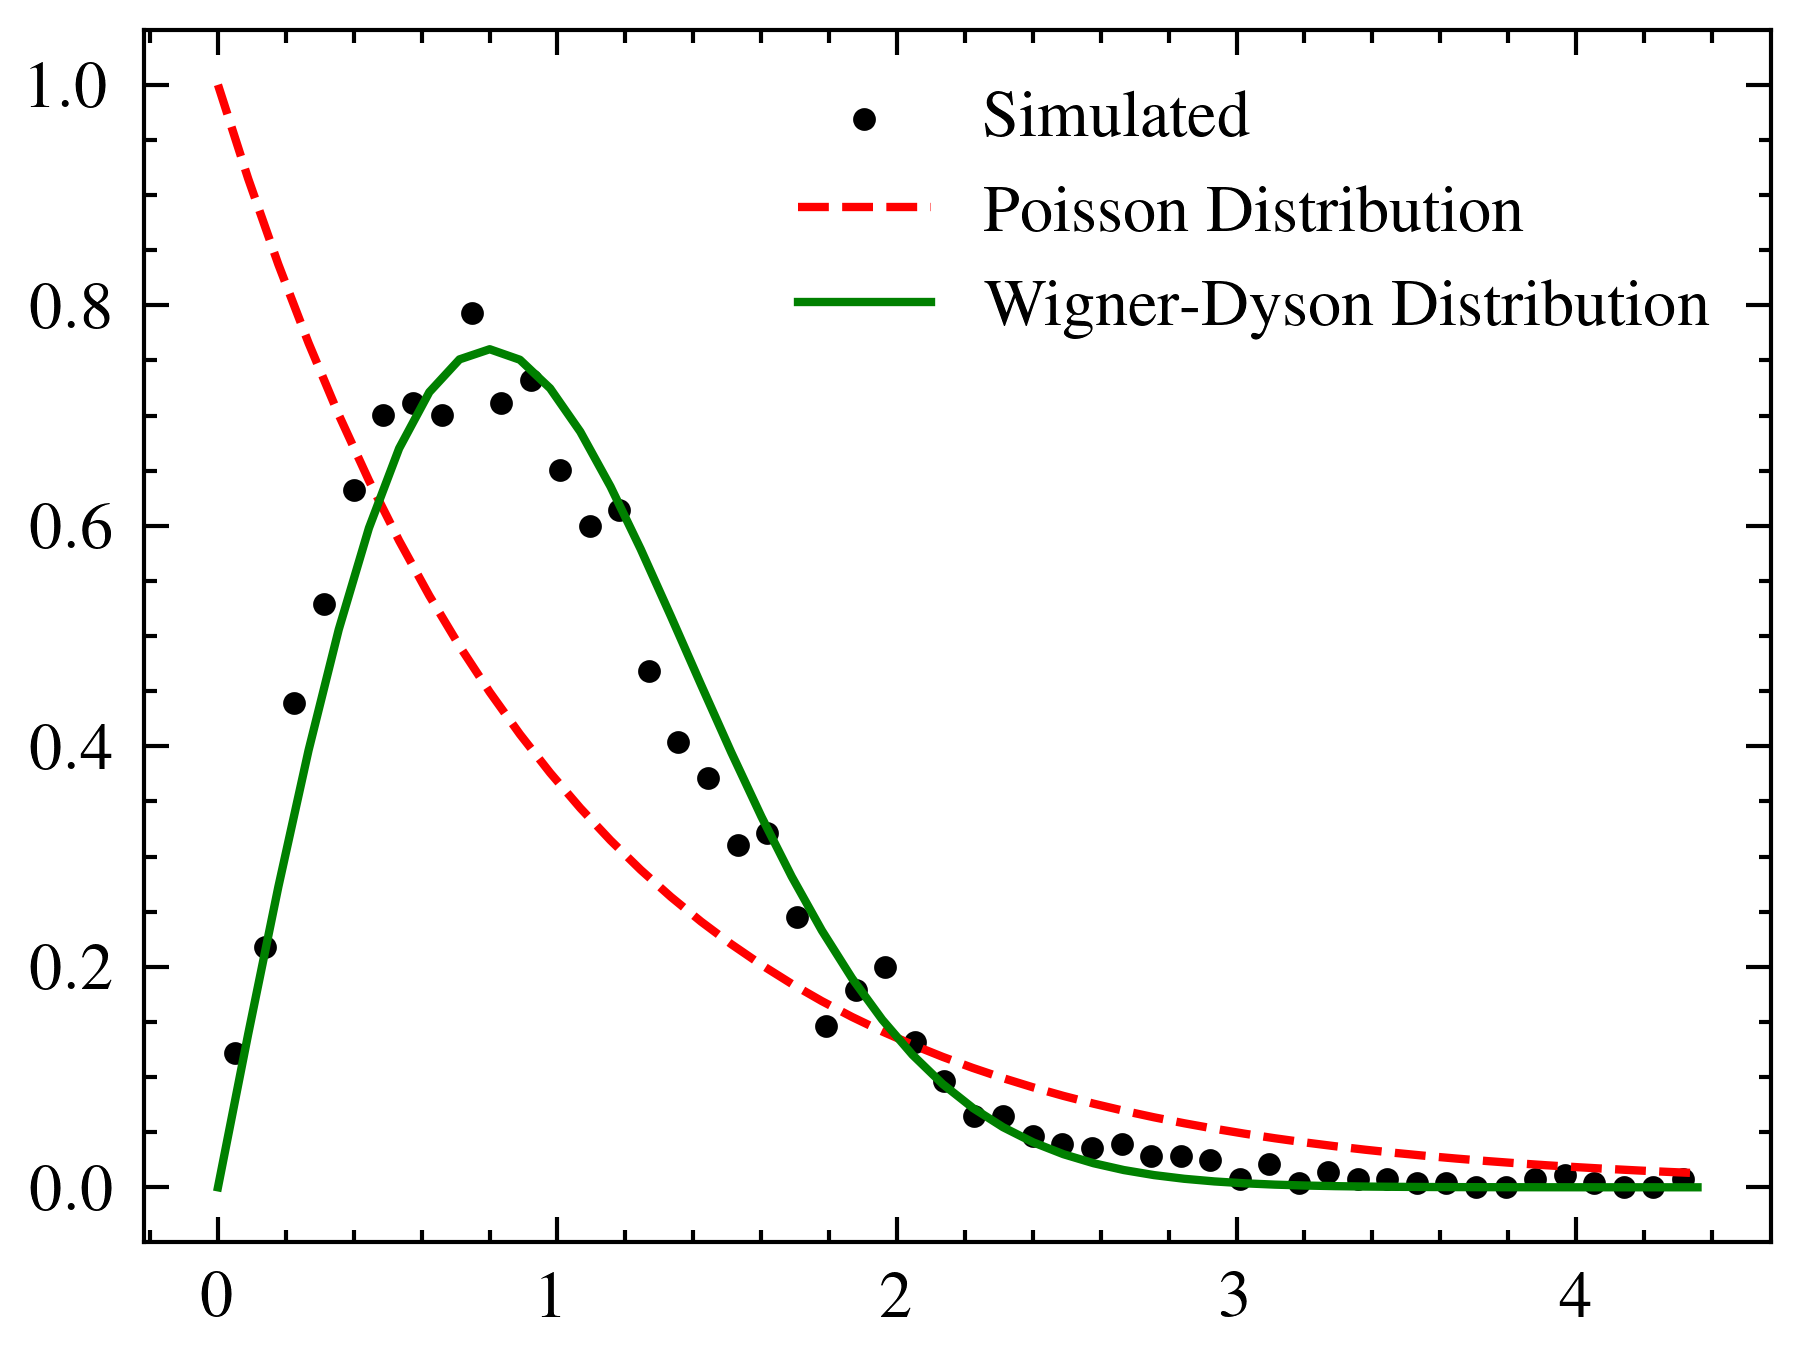

In [46]:
with plt.style.context(['science']):
    P_s,bins= np.histogram(S_i,density=True,bins=50)
    bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(P_s))]
    plt.scatter(bins_mean,P_s,label = 'Simulated',s=3,color='black')
    plt.plot(np.linspace(0,S_i.max()),Poisson,color='red',label = 'Poisson Distribution',ls='--')
    plt.plot(np.linspace(0,S_i.max()),Wigner_Dyson,color='green',label = 'Wigner-Dyson Distribution')
    plt.legend()

In [119]:
len(P_s)

50

In [25]:
eigen_entropies = []
for i in range(len(eigenvalues)):
    eigen_entropies.append(basis.ent_entropy(eigenvectors[:,i],sub_sys_A = [0,1,2,3])['Sent_A']/L)

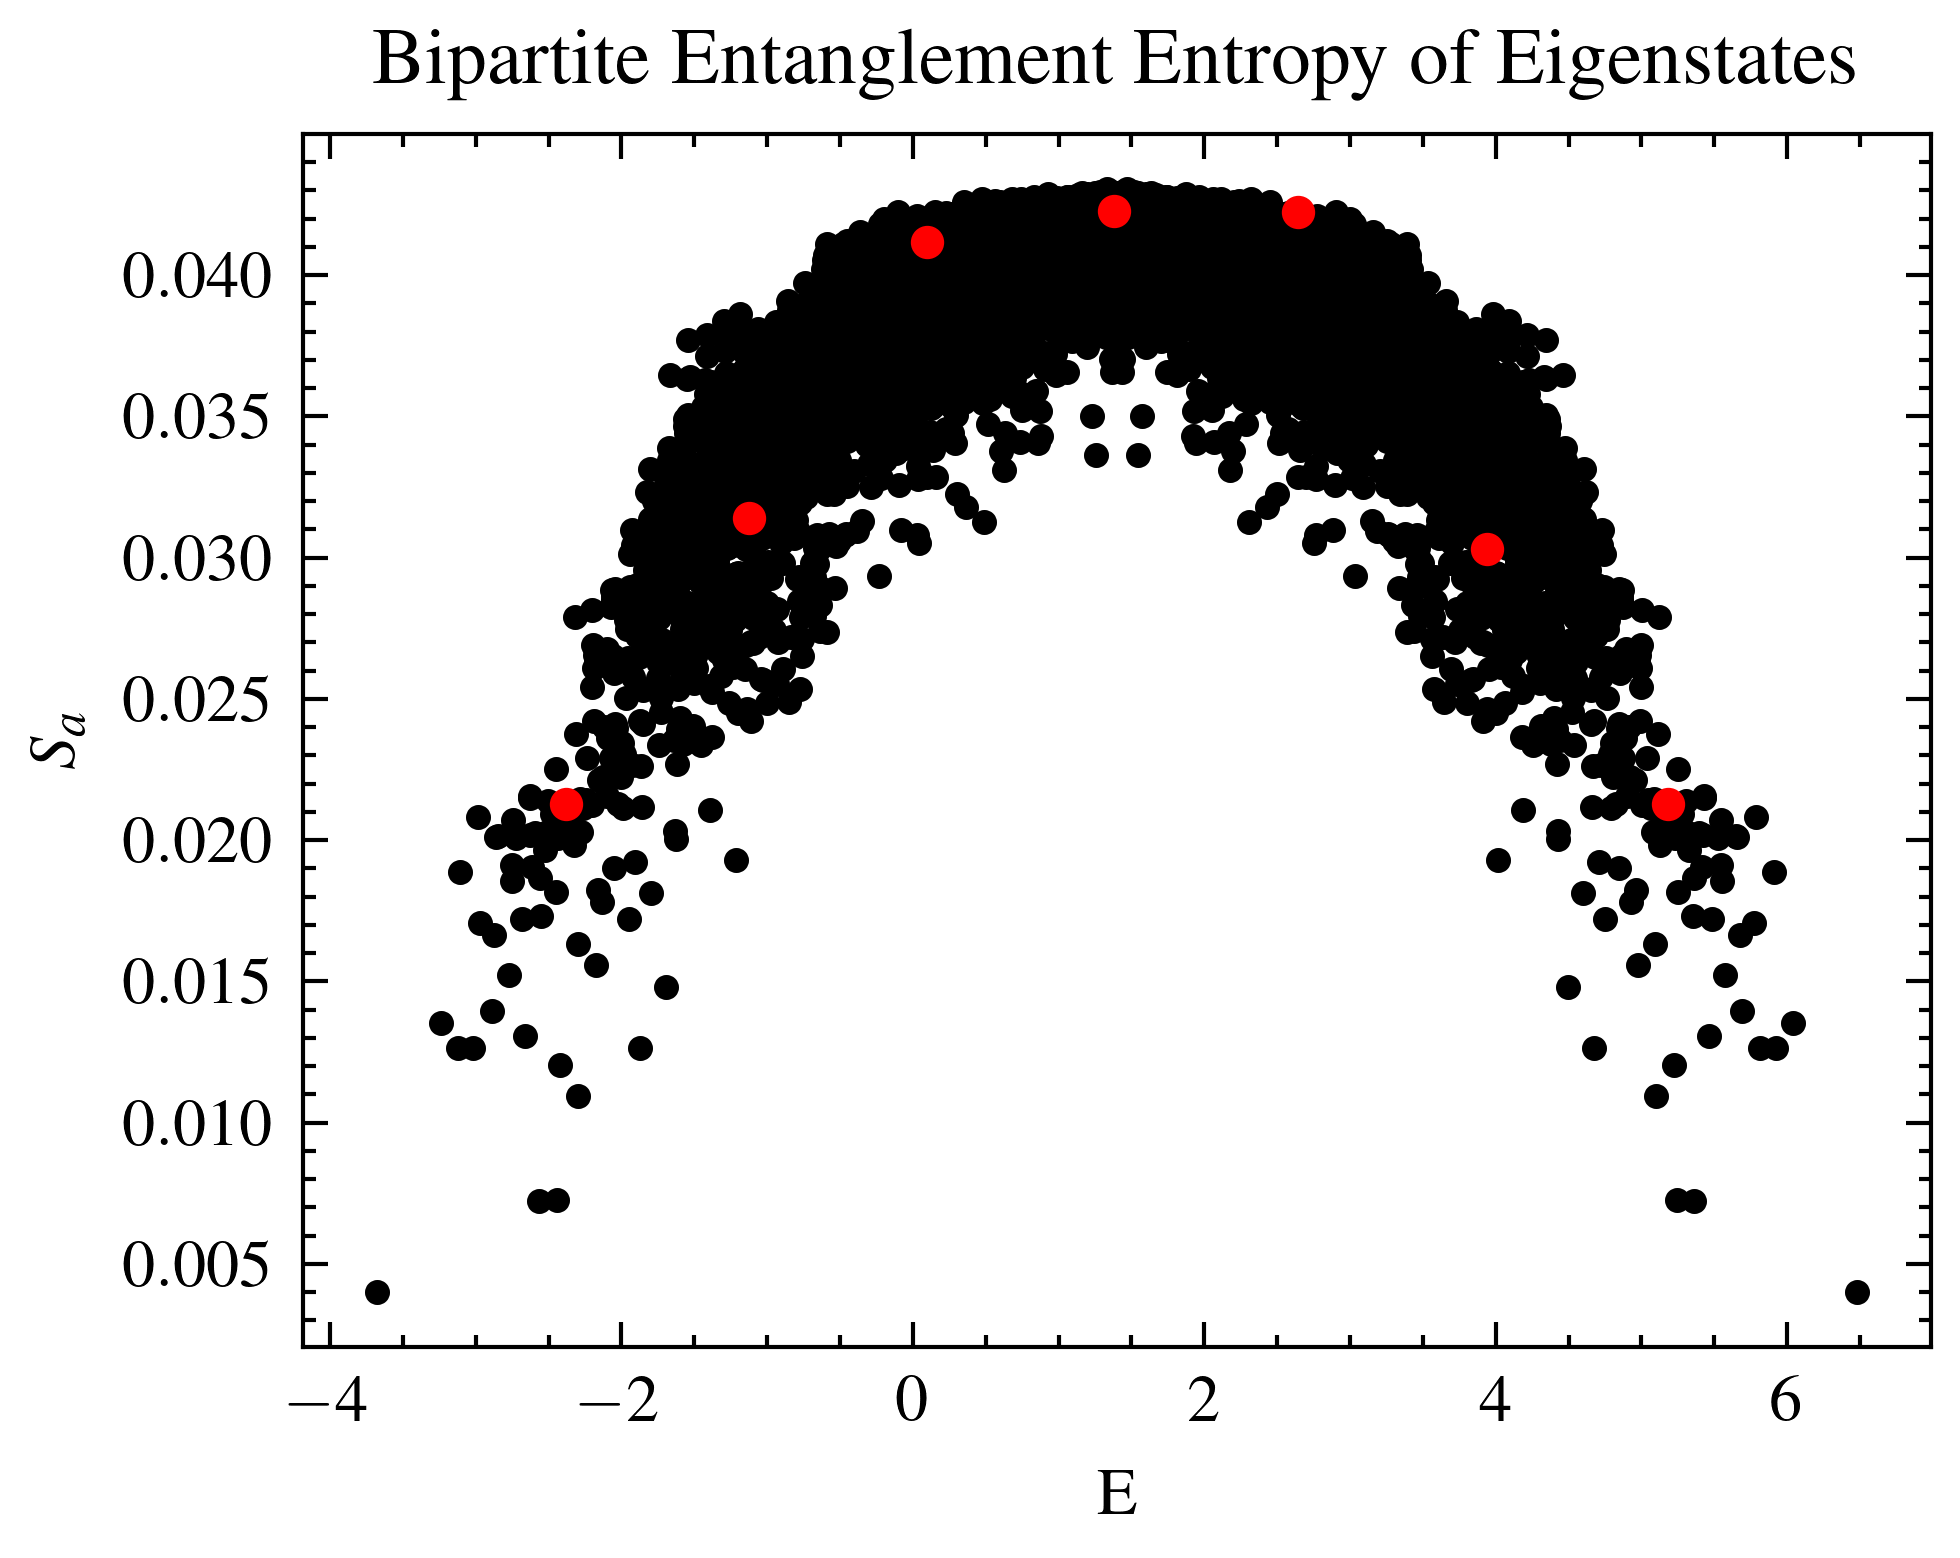

In [336]:
with plt.style.context(['science', 'scatter']):
    plt.title('Bipartite Entanglement Entropy of Eigenstates')
    plt.scatter(eigenvalues/L,eigen_entropies,s=4,color='black')
    plt.scatter(En_s_i ,S_z_i,c ='red')
    plt.xlabel('E')
    plt.ylabel(r'$S_a$')


In [173]:
test = basis.get_vec(psi_t[:,3])
test

<65536x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 12870 stored elements in Compressed Sparse Column format>

In [121]:
psi_0 * H

ValueError: shapes do not match

In [195]:
psi_t[i_0,0]

(1+0j)

In [183]:
psi_s=np.zeros(basis.Ns)
# obtain array index for the fock state |01>
array_ind_s=basis.index( basis[1] )
# construct the pure state |01>
psi_s[array_ind_s]=1.0


print state psi_s in the basis:
[0. 1. 0. ... 0. 0. 0.]


In [201]:
len(psi_t)

12870

In [143]:
eigenvectors[:,3].T.conjugate()@H.dot(eigenvectors[:,1])

(2.5318636076576695e-13+0j)

In [212]:
def QFI(Psi_i,Psi_j,P_i,P_j, H ):
    QFI = 0 
    for i in range(len(eigenvectors_i)):
        for j in range(len(eigenvectors_i)):
            if i != j:
                QFI += ((P_i-P_j)**2)/(P_i+P_j) * abs(eigenvectors[:,i].T.conjugate()@H.dot(Psi_J[:,j]))**2
    return QFI/2 

def QFI2(Psi_t, H ):
    QFI = 0 
    for i in range(len(psi_t)):
        psi_i=np.zeros(basis.Ns)
        # obtain array index for the fock state |01>
        array_ind_s=basis.index( basis[i] )
        # construct the pure state |01>
        psi_s[array_ind_s]=1.0 
        P_i = Psi_t[i]
        for j in range(len(psi_t)):
            if i != j:
                P_j = Psi_t[j]
                if P_j + P_i !=0:
                    psi_j=np.zeros(basis.Ns)
                    # obtain array index for the fock state |01>
                    array_ind_s=basis.index( basis[j] )
                    # construct the pure state |01>
                    psi_j[array_ind_s]=1.0 
                    QFI += ((P_i-P_j)**2)/(P_i+P_j) * abs(psi_i.T.conjugate()@H.dot(psi_j))**2
    return QFI/2 

In [228]:
H_QFI.quant_fluct(psi_t[:,2])

(0.27420277540041127-4.763247698328114e-17j)

In [289]:
qfis = []
qfis_t=[]
for i in range(9999):
    qfis.append((4/L)*H_QFI.quant_fluct(psi_t[:,i]))
    qfis_t.append((4/L)*H_QFI.quant_fluct(psi_t_thermal[:,i])) 

(1.279188510603935-2.0509820506786742e-20j)


In [290]:
print(np.mean(qfis[100:]))

(1.279188510603935-2.0509820506786742e-20j)


In [292]:
np.max(qfis)

(1.992762565200863-6.789435371404446e-19j)

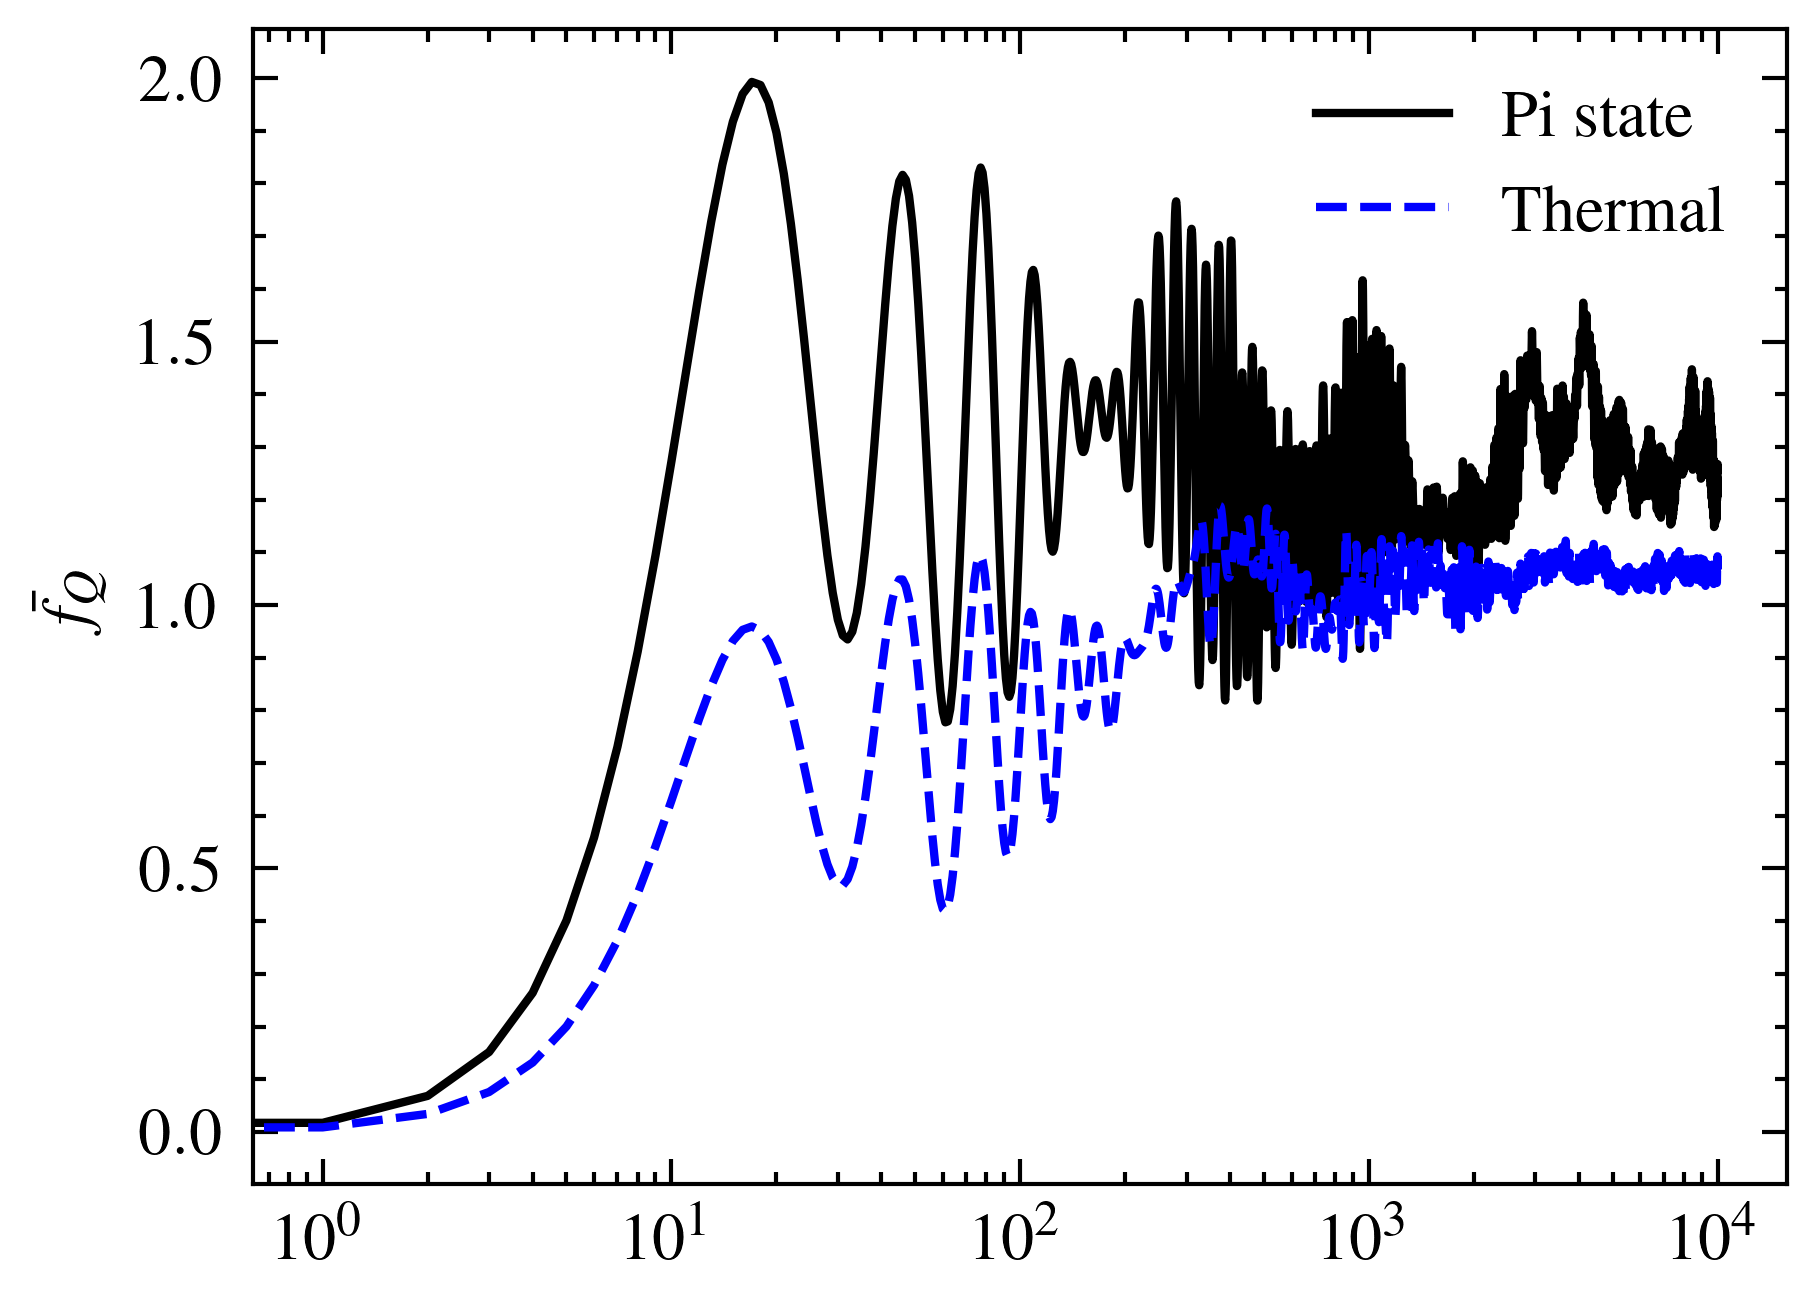

In [288]:
plt.plot(qfis, label= 'Pi state')
plt.plot(qfis_t,label= 'Thermal',color='blue',ls = '--')
plt.ylabel(r'$\bar{f _Q}$')
plt.legend()
plt.xscale('log')

In [294]:
max_peaks(S_i)

NameError: name 'max_peaks' is not defined

In [295]:
find_peaks(S_i)

(array([   3,    6,    9, ..., 6425, 6428, 6431], dtype=int64), {})

In [344]:
qfi_eigenstates = []
for i in range(12870):
    qfi_eigenstates.append((4/L)*H_QFI.quant_fluct(eigenvectors[:,i]))

In [338]:
plt.scas

array([ 2.72129321e-14+0.j,  4.31817968e-15+0.j, -9.78378708e-14+0.j, ...,
       -1.14601402e-15+0.j, -6.79426023e-16+0.j,  7.49329879e-17+0.j])

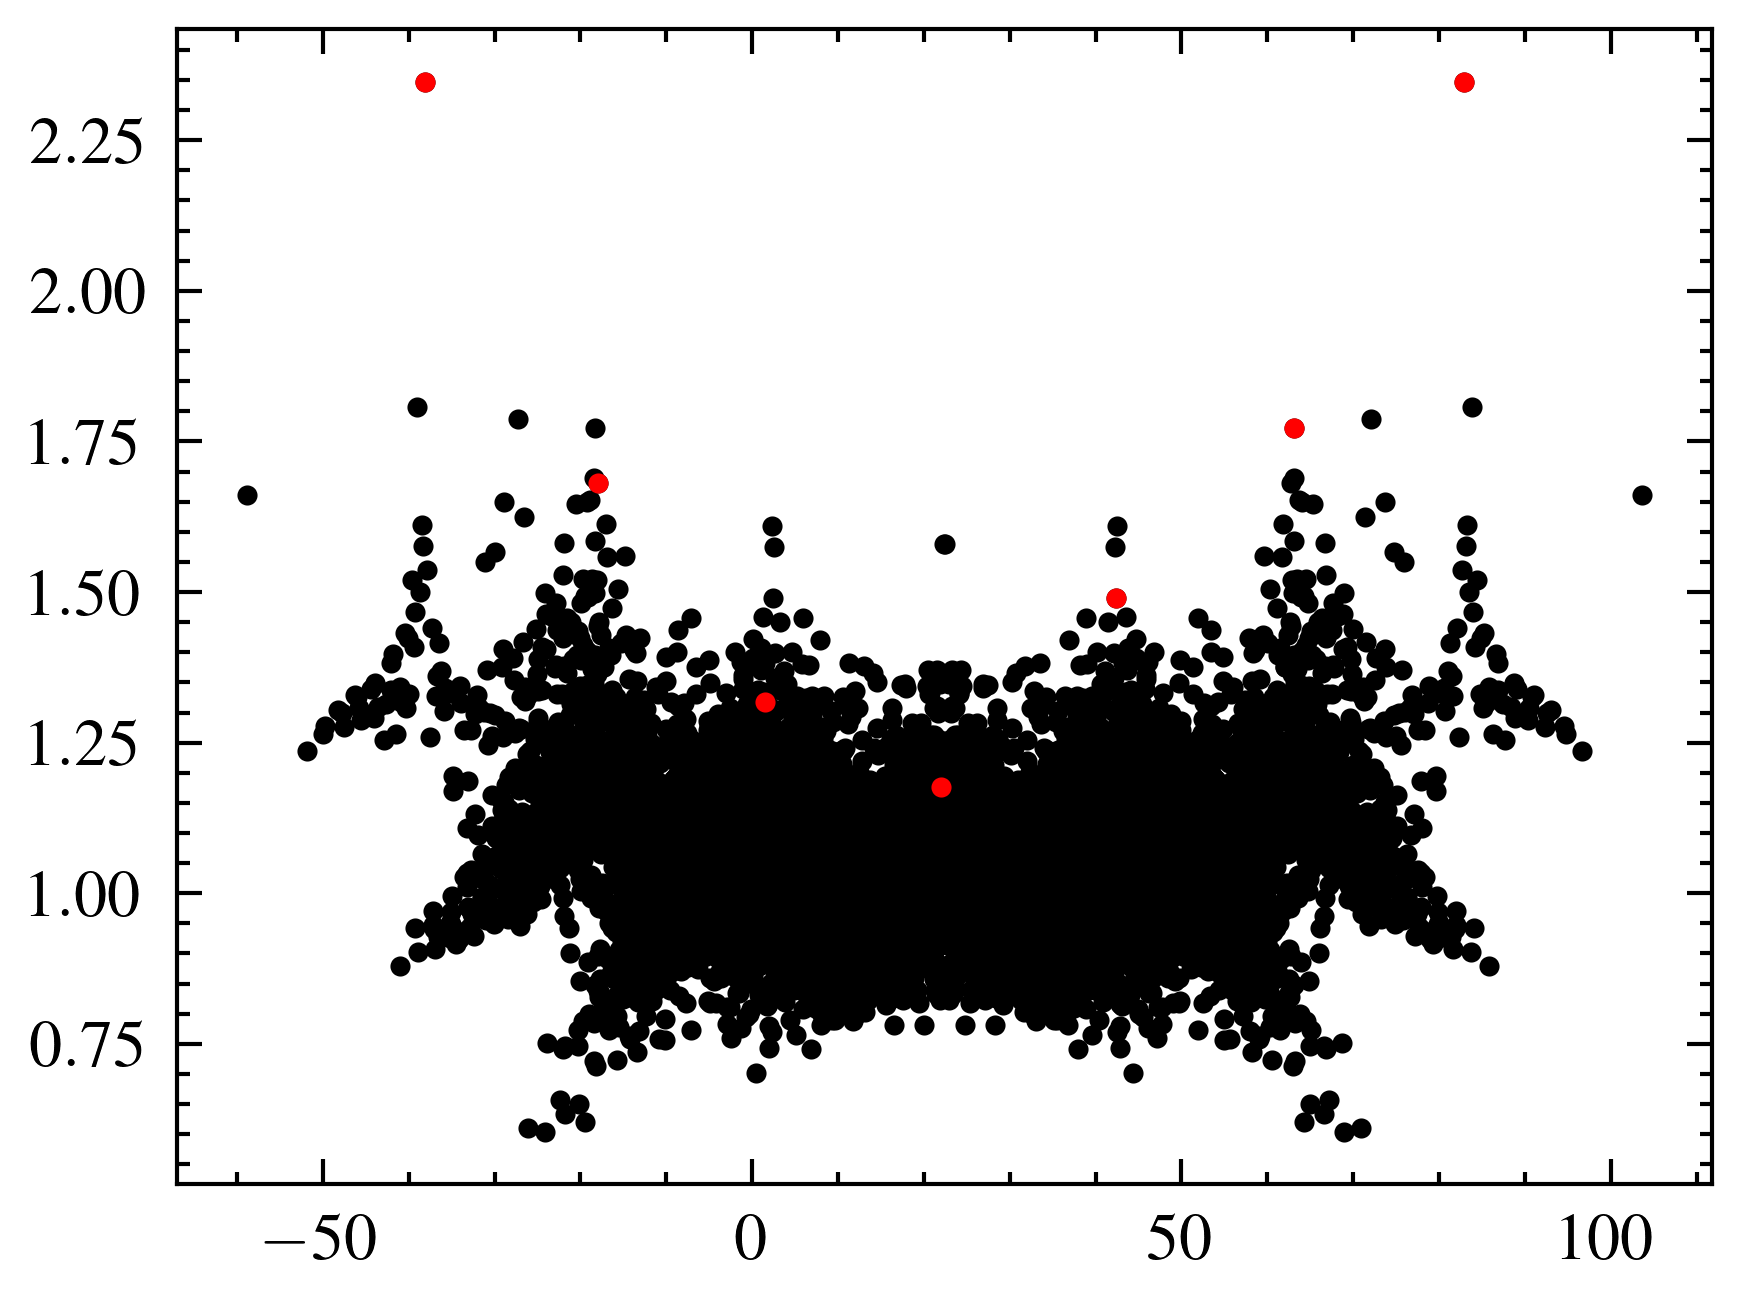

In [353]:
plt.scatter(eigenvalues,qfi_eigenstates, s=2,color='black')
plt.scatter(En_zI,peak_qfi,s=2,c='red')

In [343]:
len(eigenvalues)

12870

In [349]:
peak_qfi=[]
for i in z:
    peak_qfi.append(qfi_eigenstates[i])